In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import itertools
from tqdm import tqdm

# Proyecto 1: _Mixed graphical model sampler_: Generador de bachilleres colombianos
## Computación científica avanzada
### Maestría en Física
#### Instituto de Física, Universidad de Antioquia

## Lectura de parámetros del modelo

In [2]:
# Path to the JSON file
json_file_path = "parameters_mgm.json"

# Read JSON file
with open(json_file_path, "r") as json_file:
    theta = json.load(json_file)

## Métodos

In [3]:
def alpha(s, xs):
    """
    Compute intercept of random variable X_s

    Parameters:
    s (int): Random variable index.
    xs (int or float): Realization of the random variable X_s.

    Returns:
    float: Intercept of random varibale X_s.
    """
    
    # The intercept is computed depending on whether X_s is categorial or Gaussian
    if isinstance(xs, int):
        alpha = theta["intercepts"][f"{s}"][xs-1]
    elif isinstance(xs, float):
        alpha = theta["intercepts"][f"{s}"][0]*xs
    
    return alpha

def interaction(s, t, xs, xt):
    """
    Compute interaction parameter between random variables X_s and X_t.

    Parameters:
    arg1 (int): Description of arg1.
    arg2 (str): Description of arg2.

    Returns:
    float: Interaction parameter between random variables X_s and X_t.
    """

    # The interaction parameter is computed depending on whether the interaction is between categorical variables or is between a Gaussian and a categorical variable
    if isinstance(xs, int) and isinstance(xt, int):
        alpha_int = theta["interactions"][f"{s}{t}"][xs-1][xt-1]
    elif isinstance(xs, int) and isinstance(xt, float):
        alpha_int = theta["interactions"][f"{s}{t}"][xs-1][0]*xt -0.5*xt**2
    else:
        print(f" Interaction {s}{t} is not supported.")
        alpha_int = np.nan
    
    return alpha_int

def p_theta(x):
    """
    Mixed graphical model for X = [X_1,..., X_m], where X_1,..., X_m-1 are categorical variables and X_m is normally distributed.

    Parameters:
    x ([int, int,..., float]): A certain realization of the random vector X = [X_1,..., X_m].
    
    Returns:
    float: Non-normalized joint probability of x = [x_1,..., x_m].
    """
    # This model only support one Gaussian variable in the last entry of X
    if not isinstance(x[-1], float):
        return print("The last entry of the random vector must be a float.")
    
    # All intercepts are computed
    intercepts = sum([alpha(s, x[s-1]) for s in np.arange(1, len(x)+1)])
    
    # All interactions are computed
    interactions = sum([interaction(s, t, x[s-1], x[t-1]) for s, t in list(itertools.combinations(np.arange(1, len(x)+1), 2))])
    
    # Mixed graphical model: exponential representation via maximun entropy
    p_theta = np.exp(intercepts + interactions)

    return p_theta

def mgm_sampler(n_samples, levels):
    """
    n_samples samples according to the non-normalized joint probability density p_theta(x).

    Parameters:
    n_samples (int): Number of samples that will be generated.
    levels ([int, int,..., int]): List of number of categories of random variables X_1,... X_m. (levels[-1] = 1 because X_m is normally distributed.)

    Returns:
    [[int,..., int], [int,..., int],..., [float,..., float]]: List of m lists, one list per random variable. Each list has n_samples samples. 
    """

    # Number of variables of the mixed graphical model
    dim = len(levels)

    # Matrix of samples lists, one list per random variable
    x = np.zeros((dim, n_samples))
    
    # Initialization of Metropolis algorithm
    x_prev = [np.random.randint(1, levels[i]+1) for i in range(dim-1)] + [np.random.normal(0, 1)]
    
    for i in tqdm(range(n_samples)):
        # Sample new state candidate 
        x_star = [np.random.randint(1, levels[i]+1) for i in range(dim-1)] + [np.random.normal(0, 1)]

        u = np.random.uniform()
        # A is simple because our transition probability is symmetric (Metropolis only)
        A = p_theta(x=x_star)/p_theta(x=x_prev) # did we go up or down? 
    
        if u<A: # "coin flip" to see if we accept
            x_prev = x_star

        # filling each random variable sample list 
        for m in range(dim):
            x[m][i] = x_prev[m] 

    return x

    

## Resultados: generación "aleatoria" de bachilleres colombianos

In [4]:
# Generate a sample from mixed graphical model
n_samples = int(1e4)
mgm_sample = mgm_sampler(n_samples=n_samples, levels=[12, 2, 1])

100%|██████████| 10000/10000 [00:00<00:00, 21992.79it/s]


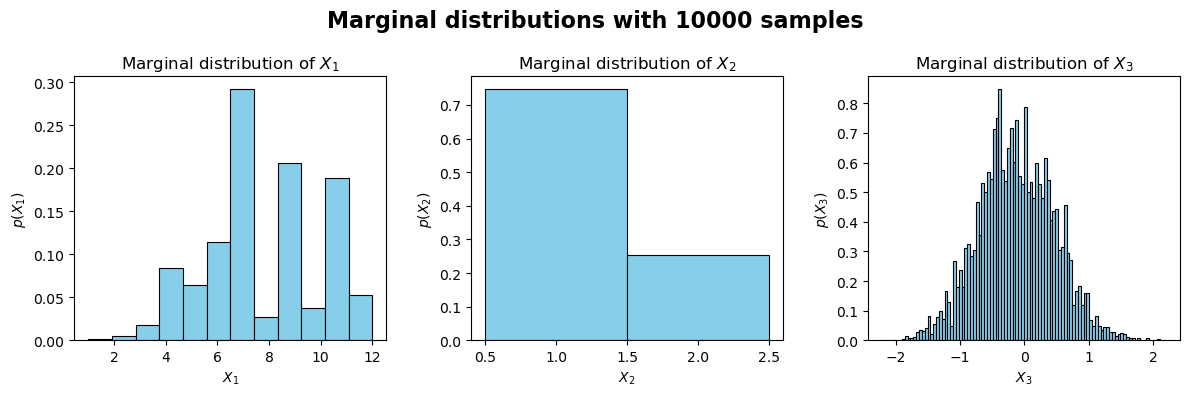

In [5]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
bar_colors = ["skyblue", "green", "red"]
bins_list = [12, [0.5, 1.5, 2.5], 100]

# Plot histograms on each subplot
for i, data in enumerate(mgm_sample):
    axs[i].hist(data, bins=bins_list[i], density=True, color='skyblue', edgecolor='black', linewidth=0.8)
    axs[i].set_title(f'Marginal distribution of $X_{i+1}$')
    axs[i].set_xlabel(f'$X_{i+1}$')
    axs[i].set_ylabel(f'$p(X_{i+1})$')

# Add a superior title above subplots
plt.suptitle(f'Marginal distributions with {n_samples} samples', fontsize=16, fontweight='bold')

# Adjust layout
plt.tight_layout()

### Comparación de las distribuciones marginales de la muestra generada y las distribuciones marginales de los datos reales

#### Datos reales

In [6]:
df_mgm = pd.read_csv("dataset_saber11_mgm_cca.csv")

In [7]:
# This dataset was used to train the mixed graphical model
df_mgm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405 entries, 0 to 8404
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fami_educacionmadre_num  8405 non-null   int64  
 1   cole_naturaleza_num      8405 non-null   int64  
 2   punt_global_scaled       8405 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 197.1 KB


#### Distribuciones marginales

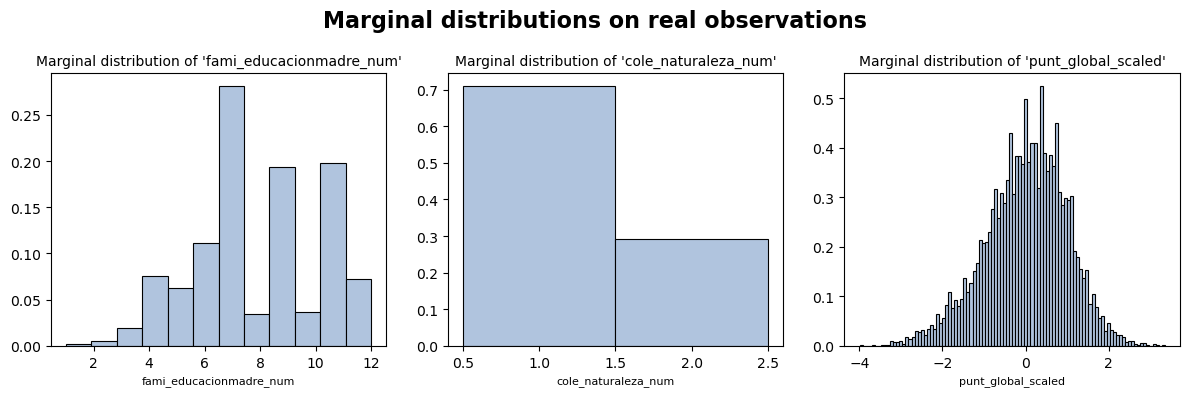

In [8]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
bar_colors = ["skyblue", "green", "red"]
bins_list = [12, [0.5, 1.5, 2.5], 100]
columns = df_mgm.columns

# Plot histograms on each subplot
for i, column in enumerate(columns):
    axs[i].hist(df_mgm[column], bins=bins_list[i], density=True, color='lightsteelblue', edgecolor='black', linewidth=0.8)
    axs[i].set_title(f"Marginal distribution of '{column}'", fontsize=10)
    axs[i].set_xlabel(f'{column}', fontsize=8)
    
# Add a superior title above subplots
plt.suptitle('Marginal distributions on real observations', fontsize=16, fontweight='bold')

# Adjust layout
plt.tight_layout()